# Context-Level Correction -  Serial Version and Spark Tuning

In [1]:
# context_correction.ipynb

######################
#
# Submission by Gioia Dominedo (Harvard ID: 40966234) for
# CS 205 - Computing Foundations for Computational Science
# 
# This is part of a joint project with Kendrick Lo that includes a
# separate component for word-level checking. This notebook outlines
# algorithms for context-level correction, and includes a serial
# Python algorithm adapted from third party algorithms (Symspell and
# Viterbi algorithms), as well as a Spark/Python algorithm. 
#
# The following were also used as references:
# Peter Norvig, How to Write a Spelling Corrector
#	(http://norvig.com/spell-correct.html)
# Peter Norvig, Natural Language Corpus Data: Beautiful Data
#	(http://norvig.com/ngrams/ch14.pdf)
#
# Two main approaches to parallelization were attempted: sentence-
# level and word-level. Both attempts are documented in this notebook.
#
######################

In [2]:
######################
#
# CONTEXT-LEVEL CORRECTION LOGIC
#
# Each sentence is modeled as a hidden Markov model. Prior
# probabilities (for first words in the sentences) and transition
# probabilities (for all subsequent words) are calculated when
# generating the main dictionary, using the same corpus. Emission
# probabilities are generated on the fly by parameterizing a Poisson 
# distribution with the edit distance. The state space of possible
# corrections is based on the suggested words from the word-level
# correction. Words must (a) be 'real' word (i.e. appear at least
# once in the corpus) used to generate the dictionary in order to be
# considered valid suggestions; this ensures that the state space
# remains manageable by ignoring words that have not been seen
# previously.
#
# All probabilities are stored in log-space to avoid underflow. Pre-
# defined minimum values are used for words that are not present in
# the dictionary and/or probability tables.
#
# More detail is included at each step below.
#
######################

### 1. Serial Code Performance

In [3]:
import re
import math
from scipy.stats import poisson
%matplotlib inline
import matplotlib.pyplot as plt

<div class="alert alert-info">
<strong>PRE-PROCESSING CODE</strong>
</div>

In [4]:
######################
#
# v 1.0 last revised 27 Nov 2015
#
# The pre-processing steps have been adapted from the dictionary
# creation of the word-level spellchecker, which in turn was based on
# SymSpell, a Symmetric Delete spelling correction algorithm
# developed by Wolf Garbe and originally written in C#. More detail
# on SymSpell is included in the word-level spell-check documentation.
#
# The main modifications to the word-level spellchecker pre-
# processing stages are to create the additional outputs that are
# required for the context-level checking, and to eliminate redundant
# outputs that are not necessary.
#
# The outputs of the pre-processing stage are:
#
# - dictionary: A dictionary that combines both words present in the
# corpus and other words that are within a given 'delete distance'. 
# The format of the dictionary is:
# {word: ([list of words within the given 'delete distance'], 
# word count in corpus)}
#
# - start_prob: A dictionary with key, value pairs that correspond to
# (word, probability of the word being the first word in a sentence)
#
# - transition_prob: A dictionary of dictionaries that stores the
# probability of a given word following another. The format of the
# dictionary is:
# {previous word: {word1 : P(word1|prevous word), word2 : 
# P(word2|prevous word), ...}}
#
# - longest_word_length: The length of the longest word that is
# encountered in the corpus.
#
# - default_start_prob: A benchmark probability of a word being at
# the start of a sentence, set to 1 / # of unique words at the
# beginning of sentences. This ensures that all previously unseen
# words at the beginning of sentences are not corrected unnecessarily.
#
# - default_transition_prob: A benchmark probability of a word being
# seen, given the previous word in the sentence, also set to 1 / # of
# words in corpus. This ensures that all previously unseen
# transitions are not corrected unnecessarily.
#
######################

In [5]:
MAX_EDIT_DISTANCE = 3

In [6]:
def get_deletes_list(w):
    '''
    Given a word, derive strings with up to max_edit_distance
    characters deleted.
    '''
    deletes = []
    queue = [w]
    for d in range(MAX_EDIT_DISTANCE):
        temp_queue = []
        for word in queue:
            if len(word)>1:
                for c in range(len(word)):  # character index
                    word_minus_c = word[:c] + word[c+1:]
                    if word_minus_c not in deletes:
                        deletes.append(word_minus_c)
                    if word_minus_c not in temp_queue:
                        temp_queue.append(word_minus_c)
        queue = temp_queue
        
    return deletes

In [7]:
def create_dictionary_entry(w, dictionary, longest_word_length):
    '''
    Adds a word and its derived deletions to the dictionary.
    Dictionary entries are of the form:
    (list of suggested corrections, frequency of word in corpus)
    '''

    new_real_word_added = False
    
    # check if word is already in dictionary
    if w in dictionary:
        # increment count of word in corpus
        dictionary[w] = (dictionary[w][0], dictionary[w][1] + 1)
    else:
        # create new entry in dictionary
        dictionary[w] = ([], 1)  
        longest_word_length = max(longest_word_length, len(w))
        
    if dictionary[w][1]==1:
        
        # first appearance of word in corpus
        # n.b. word may already be in dictionary as a derived word
        # (deleting character from a real word)
        # but counter of frequency of word in corpus is not
        # incremented in those cases)
        
        new_real_word_added = True
        deletes = get_deletes_list(w)
        
        for item in deletes:
            if item in dictionary:
                # add (correct) word to delete's suggested correction
                # list if not already there
                if item not in dictionary[item][0]:
                    dictionary[item][0].append(w)
            else:
                # note: frequency of word in corpus is not incremented
                dictionary[item] = ([w], 0)  
        
    return new_real_word_added, longest_word_length

In [8]:
def create_dictionary(fname):
    '''
    Loads a text file and uses it to create a dictionary and
    to calculate start probabilities and transition probabilities. 
    Please refer to the text above for a full description.
    '''
    
    print 'Creating dictionary...'

    dictionary = dict()
    longest_word_length = 0
    start_prob = dict()
    transition_prob = dict()
    word_count = 0
    
    with open(fname) as file:    
        
        for line in file:
            
            # process each sentence separately
            for sentence in line.split('.'):
                
                # separate by words by non-alphabetical characters
                words = re.findall('[a-z]+', sentence.lower())      
                
                for w, word in enumerate(words):
                    
                    new_word, longest_word_length = \
                        create_dictionary_entry(word, dictionary,
                                                longest_word_length)
                    
                    if new_word:
                        word_count += 1
                        
                    # update probabilities for Hidden Markov Model
                    if w == 0:

                        # probability of a word being at the
                        # beginning of a sentence
                        if word in start_prob:
                            start_prob[word] += 1
                        else:
                            start_prob[word] = 1
                    else:
                        
                        # probability of transitionining from one
                        # word to another
                        # dictionary format:
                        # {previous word: {word1 : P(word1|prevous
                        # word), word2 : P(word2|prevous word)}}
                        
                        # check that prior word is present
                        # - create if not
                        if words[w - 1] not in transition_prob:
                            transition_prob[words[w - 1]] = dict()
                            
                        # check that current word is present
                        # - create if not
                        if word not in transition_prob[words[w - 1]]:
                            transition_prob[words[w - 1]][word] = 0
                            
                        # update value
                        transition_prob[words[w - 1]][word] += 1
                    
    # convert counts to log-probabilities, to avoid underflow in
    # later calculations (note: natural logarithm, not base-10)
    
    total_start_words = float(sum(start_prob.values()))
    default_start_prob = math.log(1/total_start_words)
    start_prob.update( 
        {k: math.log(v/total_start_words)
         for k, v in start_prob.items()})
    
    default_transition_prob = math.log(1./word_count)    
    transition_prob.update(
        {k: {k1: math.log(float(v1)/sum(v.values()))
             for k1, v1 in v.items()} 
         for k, v in transition_prob.items()})

    print 'Total unique words in corpus: %i' % word_count
    print 'Total items in dictionary: %i' \
        % len(dictionary)
    print '  Edit distance for deletions: %i' % MAX_EDIT_DISTANCE
    print '  Length of longest word: %i' % longest_word_length
    print 'Total unique words at the start of a sentence: %i' \
        % len(start_prob)
    print 'Total unique word transitions: %i' % len(transition_prob)
        
    return dictionary, longest_word_length, start_prob, \
        default_start_prob, transition_prob, default_transition_prob

In [9]:
# %%time
# dictionary, longest_word_length, \
# start_prob, default_start_prob, \
# transition_prob, default_transition_prob \
# = create_dictionary('testdata/big.txt')

```
Creating dictionary...  
Total unique words in corpus: 29157  
Total items in dictionary (corpus words and deletions): 2151998  
  Edit distance for deletions: 3  
  Length of longest word in corpus: 18  
Total unique words appearing at the start of a sentence: 15297  
Total unique word transitions: 27224  
CPU times: user 34.7 s, sys: 849 ms, total: 35.5 s  
Wall time: 36.2 s 
```

<div class="alert alert-info">
<strong>SPELL-CHECKING CODE</strong>
</div>

In [10]:
######################
#
# v 1.0 last revised 27 Nov 2015
#
# Reads in a text file, breaks it down into individual sentences (by
# splitting on periods), and then carries out context-based spell-
# checking on each sentence in turn. In cases where the 'suggested'
# word does not match the actual word in the text, both the original
# and the suggested sentences are printed.
#
# Probabilistic model:
#
# Each sentence is modeled as a hidden Markov model, where the
# hidden states are the words that the user intended to type, and
# the emissions are the words
# that were actually typed.
#
# For each word in a sentence, we can define:
# - emission probabilities: P(word typed|word intended)
# - prior probabilities (for first words in sentences only):
# P(being the first word in a sentence)
# - transition probabilities (for all subsequent words):
# P(word intended|previous word intended)
#
# Prior and transition probabilities were calculated in the pre-
# processing step, using the same corpus as the dictionary.
# 
# Emission probabilities are calculated on the fly using a Poisson
# distribution, where P(word typed|word intended) = PMF of 
# Poisson(k, l), where k = edit distance between word type and word
# intended, and l=0.01. This approach was taken from the 2015
# lecture notes of AM207 Stochastic Optimization, as was the
# parameter l=0.01. Various parameters between 0 and 1 were tested,
# confirming that 0.01 yields the most accurate word suggestions.
# The shape of the PMF is shown in the cell below.
#
# All probabilities are stored in log-space to avoid underflow. Pre-
# defined minimum values (also defined at the pre-processing stage)
# are used for words that are not present in the dictionary and/or
# probability tables.
#
# The spell-checking itself is carried out using a modified version
# of the Viterbi algorithm, which yields the most likely sequence of
# hidden states, i.e. the most likely sequence of words that the
# user intended to type. The main difference to the 'standard'
# Viterbi algorithm is that the state space (i.e. list of possible
# corrections) is generated (and therefore varies) for each word,
# instead of considering the state space of all possible words in
# the dictionary for every word that is checked. This ensures that
# the problem remains tractable.
#
# The algorithm is best illustrated by way of an example.
# e.g. suppose that we are checking the sentence 'This is ax test.'
# The emissions are 'This is ax test.' and the hidden states are
# 'This is a test.'
#
# As a pre-processing step, we convert everything to lowercase,
# eliminate punctuation, and break the sentence up into a list of
# words: ['this', 'is', 'ax', 'text']
# This list is passed as a parameter to the viterbi function.
#
# The algorithm tackles each word in turn, starting with 'this'.
#
# We first use get_suggestions to obtain a list of all words that
# may have been intended, i.e. all possible hidden states (intended
# words) for the emission (word typed).
# get_suggestions returns 1,004 possible corrections, including:
# - 1 word with an edit distance of 0 ['this']
# - 2 words with an edit distance of 1 ['his', 'thus', 'thin',
# 'tis', 'thins']
# - 109 words with an edit distance of 2 ['the', 'that', 'is',
# 'him', 'they', ...]
# - 889 words with an edit distance of 3 ['to', 'in', 'he', 'was',
# 'it', 'as', ...]
# Note: get_suggestions is capped at an edit distance of 3.
# 
# These 1,004 words represent our state space, i.e. all possible
# words that may have been intended. They each have an emission
# probability = PMF of Poisson(edit distance, 0.01)
# We refer to this below as the list of possible corrections.
#
# For each word in the list of possible corrections, we calculate:
# P(word starting a sentence) * P(typing 'this'|meaning to type word)
# This is a simple application of Bayes' rule: by normalizing the
# probabilities we obtain P(meaning to type word|typing 'this') for
# each of the 1,004 words.
# These probabilities are referred to as the belief state, and they
# are stored for
# future use. We also store the possible paths, which at this stage
# are only one word long.
# 
# We now move on to the next word. After the first word, all
# subsequent words are
# treated as follows.
#
# The second word in our test sentence is 'is'. Once again, we use
# get_suggestions to obtain a list of all words that may have been
# intended. get_suggestions returns 1,124 possible corrections,
# including:
# - 1 word with an edit distance of 0 ['is']
# - 31 words with an edit distance of 1 ['in', 'it', 'his', 'as',
# 'i', ...]
# - 213 words with an edit distance of 2 ['was', 'him', 'this',
# 'so', 'did', ...]
# - 879 words with an edit distance of 3 ['with', 'she', 'said',
# 'into', ...]
# These 1,124 words represent our state space for the second word.
#
# For each word in the list of possible corrections, we loop through
# all the words in the previous list of possible corrections, and
# calculate:
# belief state(previous word) * P(current word|previous word)
#    * P(typing 'is'|meaning to type current word)
# We store the previous word that maximizes this calculation, as
# well as the probability that it results in.
#
# For example, suppose that we are considering the possibility that
# 'is' was indeed intended to be 'is'. We then calculate: 
# belief state(previous word) * P('is'|previous word) * P('is'|'is')
# for all possible previous words, and discover that the previous
# word 'this' maximizes the above calculation. We therefore store
# 'this is' as the optimal path for the suggested correction 'is'
# (more specifically, path['is'] = 'this is'), and the above
# (normalized) probability as the belief state for 'is' (more
# specifically, belief['is'] = prob('this is')).
#
# If the sentence had been only 2 words long, then at this point we
# would return the path that maximizes the most recent belief state.
# As it is not, we repeat the previous steps for 'ax' and 'test',
# and then return the path that is associated with the most likely
# belief state at the last step.
#
######################

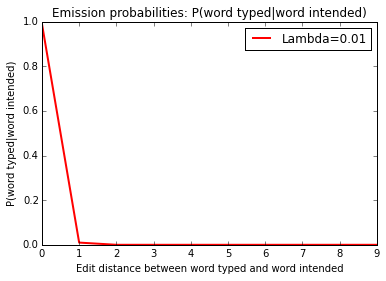

In [11]:
# emission probabilities
l = 0.01
plt.plot(range(10), [poisson.pmf(k, l) for k in range(10)], 
         color='r', linewidth=2, label='Lambda='+str(l))
plt.ylabel('P(word typed|word intended)')
plt.xlabel('Edit distance between word typed and word intended')
plt.title('Emission probabilities: P(word typed|word intended)')
plt.legend(loc='upper right')
plt.show()

In [12]:
def dameraulevenshtein(seq1, seq2):
    '''
    Calculate the Damerau-Levenshtein distance between sequences.
    Same code as word-level checking.
    '''
    
    # codesnippet:D0DE4716-B6E6-4161-9219-2903BF8F547F
    # Conceptually, this is based on a len(seq1) + 1 * len(seq2) + 1
    # matrix. However, only the current and two previous rows are
    # needed at once, so we only store those.
    
    oneago = None
    thisrow = range(1, len(seq2) + 1) + [0]
    
    for x in xrange(len(seq1)):
        
        # Python lists wrap around for negative indices, so put the
        # leftmost column at the *end* of the list. This matches with
        # the zero-indexed strings and saves extra calculation.
        twoago, oneago, thisrow = \
            oneago, thisrow, [0] * len(seq2) + [x + 1]
        
        for y in xrange(len(seq2)):
            delcost = oneago[y] + 1
            addcost = thisrow[y - 1] + 1
            subcost = oneago[y - 1] + (seq1[x] != seq2[y])
            thisrow[y] = min(delcost, addcost, subcost)
            # This block deals with transpositions
            if (x > 0 and y > 0 and seq1[x] == seq2[y - 1]
                and seq1[x-1] == seq2[y] and seq1[x] != seq2[y]):
                thisrow[y] = min(thisrow[y], twoago[y - 2] + 1)
                
    return thisrow[len(seq2) - 1]

In [13]:
def get_suggestions(string, dictionary, 
                    longest_word_length, min_count):
    '''
    Return list of suggested corrections for potentially incorrectly
    spelled word.
    Code based on get_suggestions function from word-level checking,
    with the addition of the min_count parameter, which only
    considers words that have occur more than min_count times in the
    (dictionary) corpus.
    '''
    
    if (len(string) - longest_word_length) > MAX_EDIT_DISTANCE:
        return []
    
    suggest_dict = {}
    
    queue = [string]
    q_dictionary = {}  # items other than string that we've checked
    
    while len(queue)>0:
        q_item = queue[0]  # pop
        queue = queue[1:]
        
        # process queue item
        if (q_item in dictionary) and (q_item not in suggest_dict):
            if (dictionary[q_item][1]>=min_count):
            # word is in dictionary, and is a word from the corpus,
            # and not already in suggestion list so add to suggestion
            # dictionary, indexed by the word with value (frequency
            # in corpus, edit distance)
            # note: q_items that are not the input string are shorter
            # than input string since only deletes are added (unless
            # manual dictionary corrections are added)
                assert len(string)>=len(q_item)
                suggest_dict[q_item] = \
                    (dictionary[q_item][1], len(string) - len(q_item))
            
            # the suggested corrections for q_item as stored in
            # dictionary (whether or not q_item itself is a valid
            # word or merely a delete) can be valid corrections
            for sc_item in dictionary[q_item][0]:
                if (sc_item not in suggest_dict):
                    
                    # compute edit distance
                    # suggested items should always be longer (unless
                    # manual corrections are added)
                    assert len(sc_item)>len(q_item)
                    # q_items that are not input should be shorter
                    # than original string 
                    # (unless manual corrections added)
                    assert len(q_item)<=len(string)
                    if len(q_item)==len(string):
                        assert q_item==string
                        item_dist = len(sc_item) - len(q_item)

                    # item in suggestions list should not be the same
                    # as the string itself
                    assert sc_item!=string           
                    # calculate edit distance using Damerau-
                    # Levenshtein distance
                    item_dist = dameraulevenshtein(sc_item, string)
                    
                    if item_dist<=MAX_EDIT_DISTANCE:
                        # should already be in dictionary if in
                        # suggestion list
                        assert sc_item in dictionary  
                        # trim list to contain state space
                        if (dictionary[q_item][1]>=min_count): 
                            suggest_dict[sc_item] = \
                                (dictionary[sc_item][1], item_dist)
        
        # now generate deletes (e.g. a substring of string or of a
        # delete) from the queue item as additional items to check
        # -- add to end of queue
        assert len(string)>=len(q_item)
        if (len(string)-len(q_item))<MAX_EDIT_DISTANCE \
            and len(q_item)>1:
            for c in range(len(q_item)): # character index        
                word_minus_c = q_item[:c] + q_item[c+1:]
                if word_minus_c not in q_dictionary:
                    queue.append(word_minus_c)
                    # arbitrary value to identify we checked this
                    q_dictionary[word_minus_c] = None

    # return list of suggestions:
    # (correction, (frequency in corpus, edit distance)):
    as_list = suggest_dict.items()
    return sorted(as_list, key = \
                  lambda (term, (freq, dist)): (dist, -freq))

    '''
    Output format:
    get_suggestions('file')
    [('file', (5, 0)),
     ('five', (67, 1)),
     ('fire', (54, 1)),
     ('fine', (17, 1))...]  
    '''

In [14]:
def get_emission_prob(edit_dist, poisson_lambda=0.01):
    '''
    The emission probability, i.e. P(word typed|word intended)
    is approximated by a Poisson(k, l) distribution, where 
    k=edit distance and l=0.01.
    
    The lambda parameter matches the one used in the AM207
    lecture notes. Various parameters between 0 and 1 were tested
    to confirm that 0.01 yields the most accurate results.
    '''
    
    return math.log(poisson.pmf(edit_dist, poisson_lambda))

In [15]:
######################
# Multiple helper functions are used to avoid KeyErrors when
# attempting to access values that are not present in dictionaries,
# in which case the previously specified default value is returned.
######################

In [16]:
def get_start_prob(word, start_prob, default_start_prob):
    try:
        return start_prob[word]
    except KeyError:
        return default_start_prob

In [17]:
def get_transition_prob(cur_word, prev_word, transition_prob, default_transition_prob):
    try:
        return transition_prob[prev_word][cur_word]
    except KeyError:
        return default_transition_prob

In [18]:
def get_belief(prev_word, prev_belief):
    try:
        return prev_belief[prev_word]
    except KeyError:
        return math.log(math.exp(min(prev_belief.values()))/2.)

In [19]:
def viterbi(words, dictionary, longest_word_length,
            start_prob, default_start_prob, 
            transition_prob, default_transition_prob,
            min_count=1,num_word_suggestions=5000):
    
    V = [{}]
    path = {}
    path_context = []
    
    # character level correction - used to determine state space
    corrections = get_suggestions(
        words[0], dictionary, longest_word_length, min_count)

    # to ensure Viterbi can keep running
    # -- use the word itself if no corrections are found
    if len(corrections) == 0:
        corrections = [(words[0], (1, 0))]
    else:    
        if len(corrections) > num_word_suggestions:
            corrections = corrections[0:num_word_suggestions]
        
    # Initialize base cases (t == 0)
    for sug_word in corrections:
        
        # compute the value for all possible starting states
        V[0][sug_word[0]] = math.exp(
            get_start_prob(sug_word[0], start_prob, 
                           default_start_prob)
            + get_emission_prob(sug_word[1][1]))
        
        # remember all the different paths (only one state so far)
        path[sug_word[0]] = [sug_word[0]]
 
    # normalize for numerical stability
    path_temp_sum = sum(V[0].values())
    V[0].update({k: math.log(v/path_temp_sum) 
                 for k, v in V[0].items()})
    
    # keep track of previous state space
    prev_corrections = [i[0] for i in corrections]
    
    if len(words) == 1:
        path_context = [max(V[0], key=lambda i: V[0][i])]
        return path_context

    # run Viterbi for t > 0
    for t in range(1, len(words)):

        V.append({})
        new_path = {}
        
        # character level correction
        corrections = get_suggestions(
            words[t], dictionary, longest_word_length, min_count)
        
        # to ensure Viterbi can keep running
        # -- use the word itself if no corrections are found
        if len(corrections) == 0:
            corrections = [(words[t], (1, 0))]
        else:
            if len(corrections) > num_word_suggestions:
                corrections = corrections[0:num_word_suggestions]
 
        for sug_word in corrections:
        
            sug_word_emission_prob = get_emission_prob(sug_word[1][1])
            
            # compute the values coming from all possible previous
            # states, only keep the maximum
            (prob, word) = max(
                (get_belief(prev_word, V[t-1]) 
                + get_transition_prob(sug_word[0], prev_word, 
                    transition_prob, default_transition_prob)
                + sug_word_emission_prob, prev_word) 
                               for prev_word in prev_corrections)

            # save the maximum value for each state
            V[t][sug_word[0]] = math.exp(prob)
            
            # remember the path we came from to get this maximum value
            new_path[sug_word[0]] = path[word] + [sug_word[0]]
            
        # normalize for numerical stability
        path_temp_sum = sum(V[t].values())
        V[t].update({k: math.log(v/path_temp_sum) 
                     for k, v in V[t].items()})
        
        # keep track of previous state space
        prev_corrections = [i[0] for i in corrections]
 
        # don't need to remember the old paths
        path = new_path
     
    (prob, word) = max((V[t][sug_word[0]], sug_word[0]) 
                       for sug_word in corrections)
    path_context = path[word]
    
    return path_context

In [25]:
def correct_document_context(fname, dictionary, longest_word_length,
                             start_prob, default_start_prob,
                             transition_prob, default_transition_prob,
                             num_word_suggestions=5000):
    
    doc_word_count = 0
    corrected_word_count = 0
    
    with open(fname) as file:
        
        for i, line in enumerate(file):
            
            for sentence in line.split('.'):
                
                # separate by words by non-alphabetical characters
                words = re.findall('[a-z]+', sentence.lower())  
                doc_word_count += len(words)
                
                if len(words) > 0:
                
                    suggestion = viterbi(words, dictionary,
                                longest_word_length, start_prob, 
                                default_start_prob, transition_prob,
                                default_transition_prob)

                    # display sentences with corrections
                    if words != suggestion:
                        
                        # most users will expect to see 1-indexing.
                        print '\nErrors found in line %i.' % (i+1)
                        print 'Original sentence: %s' \
                            % (' '.join(words))
                        print 'Suggested correction: %s' \
                            % (' '.join(suggestion))
                        
                        # update count of corrected words
                        corrected_word_count += \
                        sum([words[j]!=suggestion[j] 
                             for j in range(len(words))])
  
    print '-----'
    print 'Total words checked: %i' % doc_word_count
    print 'Total potential errors found: %i' % corrected_word_count

In [22]:
# %%time
# correct_document_context('testdata/test.txt', dictionary,
#                          longest_word_length, start_prob,
#                          default_start_prob, transition_prob,
#                          default_transition_prob)

```
min_count = 1  

Errors found in line 4.   
Original sentence: this is ax test  
Suggested correction: this is a test  
  
Errors found in line 5.   
Original sentence: this is za test  
Suggested correction: this is a test  
  
Errors found in line 6.   
Original sentence: thee is a test  
Suggested correction: there is a test  
  
Errors found in line 7.   
Original sentence: her tee set  
Suggested correction: her the set  
----- 
Total words checked: 27  
Total potential errors found: 4  
CPU times: user 47.5 s, sys: 269 ms, total: 47.8 s  
Wall time: 48.7 s  
```

<div class="alert alert-info">
<strong>SAMPLE USAGE</strong>
</div>

<div class="alert alert-danger">
  <strong>Run the cell below only once to build the dictionary.</strong>
</div>

In [23]:
dictionary, longest_word_length, \
start_prob, default_start_prob, \
transition_prob, default_transition_prob \
= create_dictionary('testdata/big.txt')

Creating dictionary...
Total unique words in corpus: 29157
Total items in dictionary: 2151998
  Edit distance for deletions: 3
  Length of longest word: 18
Total unique words at the start of a sentence: 15297
Total unique word transitions: 27224


<div class="alert alert-success">
  <strong>Enter file name of document to correct below.</strong>
</div>

In [26]:
correct_document_context('testdata/test.txt', dictionary,
                         longest_word_length, start_prob,
                         default_start_prob, transition_prob,
                         default_transition_prob)


Errors found in line 4.
Original sentence: this is ax test
Suggested correction: this is a test

Errors found in line 5.
Original sentence: this is za test
Suggested correction: this is a test

Errors found in line 6.
Original sentence: thee is a test
Suggested correction: there is a test

Errors found in line 7.
Original sentence: her tee set
Suggested correction: her the set
-----
Total words checked: 27
Total potential errors found: 4


***
### 2. SPARK Code Performance - Parallelized Across Sentences

In [ ]:
######################
#
# CONVERT FILE INTO:
# [(sentence #, sentence)]
#
# MAP:
# [(sentence #, sentence, viterbi(sentence))]
#
# MAP:
# [(sentence #, sentence, viterbi(sentence), # of corrected words)]
#
# FILTER: # of corrected words > 0
# [(sentence #, sentence, viterbi(sentence), # of corrected words)]
#
# COLLECT/OUTPUT:
# Summary stats on corrections
#
######################

***
### 2. SPARK Code Performance - Parallelized Across Words

In [ ]:
######################
#
# CONVERT FILE INTO:
# [(sentence #, word #,), (word, previous word)]
# or None if it is the first word in the sentence
#
# SPLIT INTO 2 RDDS
# rdd1 = word # is 1
# rdd2 = word # is >1
#
# rdd1 - first words in the sentence
#
# MAP:
# [(sentence #, word #), (original word, [all word suggestions])]
#
# MAP:
# [(sentence #, word #), (original word, [tuples for all word sug of (word, emission prob)])]
#
# MAP:
# [(sentence #, word #), (original word, suggested word, emission prob * suggested word prob)],
# i.e. a list of tuples for all words in list of word suggestions
#
# FLATMAP
# [(sentence #, word #), (original word, suggested word, emission prob * suggested word prob)]
#
# REDUCE
# [(sentence #, word #), original word, suggested word]
# where suggested word is the word with maximum emission prob * suggested word prob
#
# rdd2 - all other words:
#
# MAP:
# [(sentence #, word #), (original word, [all word suggestions], [all previous word suggestions])]
#
# MAP:
# [(sentence #, word #), (original word, [tuples for all word sug of (word, emission prob)], [all previous word sug])]
#
# MAP:
# [(sentence #, word #), (original word, [tuples for all word, previous word combinations with (word, prev word, emission)])]
#
# MAP:
# [(sentence #, word #), (original word, prev word, emission prob * transition prob)],
# i.e. a list of tuples for all word, previous word combinations
#
# FIND MAX VALUE PER SENTENCE/WORD PAIR
#
# >>> COMBINE RESULTS OF RDD1 AND RDD2
# >>> CHECK HOW MANY SUGGESTIONS != ORIGINAL WORD
#
######################